In [6]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scFunctions as sf
import scFates as scf
import pickle

import liana as li


# Inital setting for plot size
from matplotlib import rcParams
FIGSIZE=(5,5)
rcParams['figure.figsize']=FIGSIZE

import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 3


%config Completer.use_jedi = False

ModuleNotFoundError: No module named 'scFunctions'

In [2]:
with open('../data/adata_epi_last.pickle', 'rb') as f1:
     adata_epi = pickle.load(f1)

In [3]:
with open('../data/adata_new_orig.pickle', 'rb') as f1:
     adata = pickle.load(f1)

In [4]:
epi_index = adata_epi.obs.index
cnv = []

for cell in adata.obs.index:
    if cell in epi_index:
        cnv.append(adata_epi.obs.loc[cell, "cnv_group"])
    else:
        cnv.append("no_cnv_computed")

stade = []
for cell in adata.obs.index:
    if cell in epi_index:
        stade.append(adata_epi.obs.loc[cell, "Stade"])
    else:
        stade.append("no_stade_computed")

adata.obs["stade"] = stade
adata.obs["cnv"] = cnv

... storing 'stade' as categorical
... storing 'cnv' as categorical


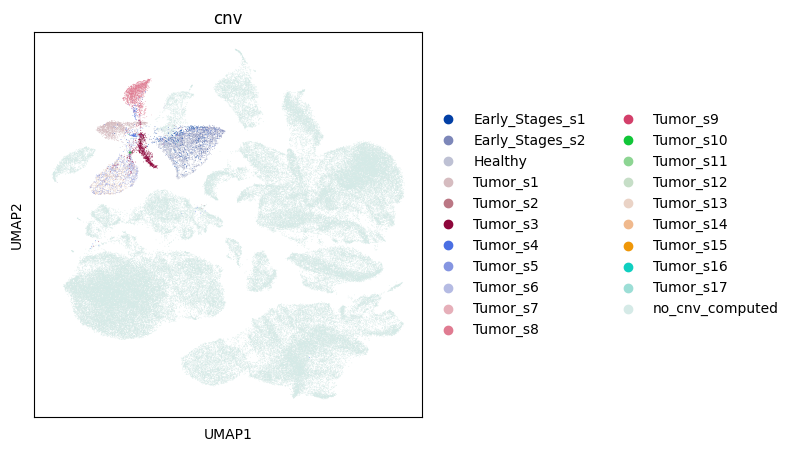

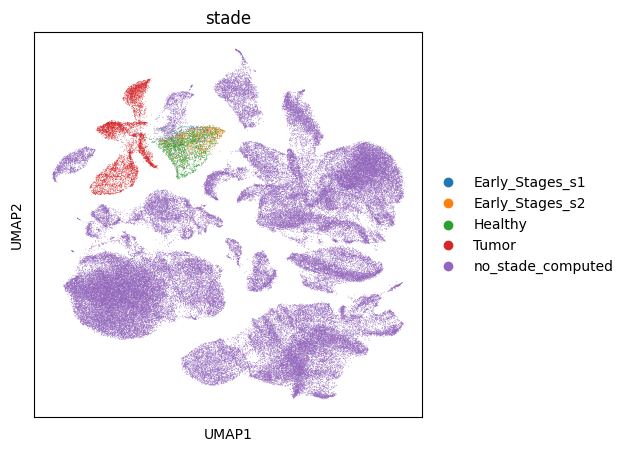

In [5]:
sc.pl.umap(adata, color = 'cnv')
sc.pl.umap(adata, color = 'stade')

In [6]:
epi_stades = adata_epi.obs.Stade.unique()
liana_column = [adata.obs.loc[i, "stade"] if adata.obs.loc[i, "stade"] in epi_stades else adata.obs.loc[i, "Population"] for i in adata.obs.index ]

In [7]:
adata.obs["liana_annot"] = liana_column

... storing 'liana_annot' as categorical


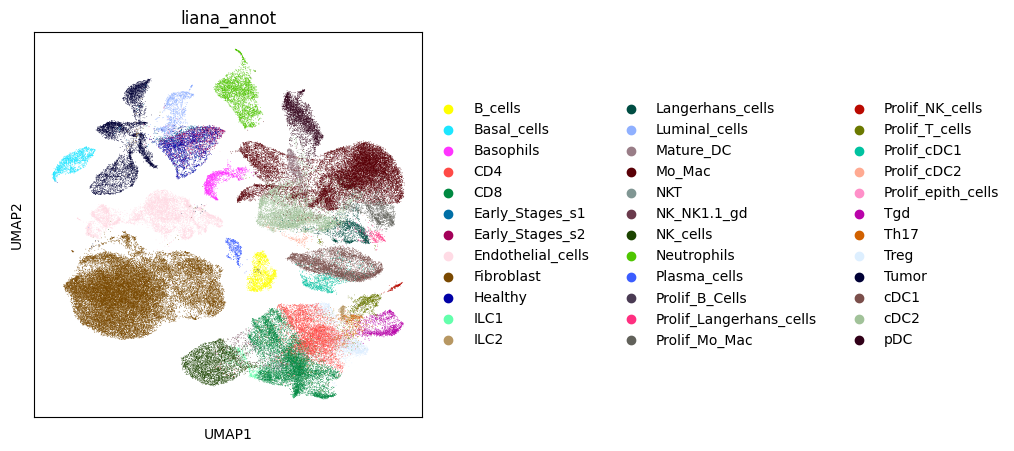

In [8]:
sc.pl.umap(adata, color = 'liana_annot')

In [9]:
adata.obs.liana_annot.value_counts()

Fibroblast                 30934
Mo_Mac                     18064
CD8                         8802
cDC2                        6292
Endothelial_cells           6031
Tumor                       5859
CD4                         5526
cDC1                        5008
NK_cells                    3823
pDC                         3153
Neutrophils                 3097
Healthy                     2376
Treg                        1981
Prolif_Mo_Mac               1799
B_cells                     1719
Basophils                   1510
Langerhans_cells            1495
Basal_cells                 1462
Tgd                         1389
Prolif_T_cells              1161
Luminal_cells               1137
Early_Stages_s2             1061
Mature_DC                   1025
Prolif_cDC1                 1008
Th17                         647
Plasma_cells                 489
Early_Stages_s1              447
ILC1                         428
NKT                          405
NK_NK1.1_gd                  317
ILC2      

In [10]:
447 + 1061 + 2376 + 5859 == len(adata_epi)

True

In [11]:
# Creer un dataframe source|target avec toutes les combinaisons avec Lt, Lb, et les différents epi

In [12]:
from itertools import product

source = ["B_cells", "CD4", "CD8"]
target = ["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"]
df_epi_target = pd.DataFrame(list(product(source, target)), columns=['source', 'target'])


df_epi_source = pd.DataFrame(list(product(target, source)), columns=['source', 'target'])

In [13]:
df_epi_source

,source,target
0,Healthy,B_cells
1,Healthy,CD4
2,Healthy,CD8
3,Early_Stages_s1,B_cells
4,Early_Stages_s1,CD4
5,Early_Stages_s1,CD8
6,Early_Stages_s2,B_cells
7,Early_Stages_s2,CD4
8,Early_Stages_s2,CD8
9,Tumor,B_cells


In [14]:
df_epi_target

,source,target
0,B_cells,Healthy
1,B_cells,Early_Stages_s1
2,B_cells,Early_Stages_s2
3,B_cells,Tumor
4,CD4,Healthy
5,CD4,Early_Stages_s1
6,CD4,Early_Stages_s2
7,CD4,Tumor
8,CD8,Healthy
9,CD8,Early_Stages_s1


# Test sur cellphoneDB pas trop concluant

In [ ]:
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean


cellphonedb(adata, groupby='liana_annot', expr_prop=0.1, 
            resource_name='mouseconsensus', verbose=True, 
            key_added='cpdb_res', groupby_pairs=df_epi_target)

Using `.raw`!
46 features of mat are empty, they will be removed.
Using resource `mouseconsensus`.
0.05 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 25790 samples and 25526 features


 76%|██████████████████████████████▍         | 761/1000 [00:23<00:07, 32.65it/s]

In [ ]:
# by default, liana's output is saved in place:
adata.uns['cpdb_res'].head()

In [ ]:
li.pl.dotplot(adata = adata,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=["CD8", "CD4"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              figure_size=(15, 15),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.001,
              uns_key='cpdb_res' # uns_key to use, default is 'liana_res'
             )

In [ ]:
my_plot = li.pl.tileplot(adata = adata,
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         top_n=10,
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=["CD8", "CD4"],
                        target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         )
my_plot


# Rank aggregate

In [ ]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='liana_annot', expr_prop=0.1, 
            resource_name='mouseconsensus', verbose=True, 
            key_added='liana_res', groupby_pairs=df_epi_target)

In [ ]:
adata.uns['liana_res'].head()

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['CD8', "CD4"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=["B_cells"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['CD8', "CD4"],
                        target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.01,
                       )
my_plot

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=["B_cells"],
                        target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.01,
                       )
my_plot

In [ ]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='liana_annot', expr_prop=0.1, 
            resource_name='mouseconsensus', verbose=True, 
            key_added='liana_res_epi_source', groupby_pairs=df_epi_source)

In [ ]:
adata.uns['liana_res_epi_source'].head()

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              target_labels=['CD8', "CD4"],
              source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_epi_source",
             )

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              target_labels=["B_cells"],
              source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_epi_source",
             )

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        target_labels=['CD8', "CD4"],
                        source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.02,
                        uns_key = "liana_res_epi_source"
                       )
my_plot

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        target_labels=["B_cells"],
                        source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.02,
                        uns_key = "liana_res_epi_source"
                       )
my_plot

# Test en prenant en compte tous les types cellulaires

In [ ]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='liana_annot', expr_prop=0.1, 
            resource_name='mouseconsensus', verbose=True, 
            key_added='liana_res_all')

# Prend 1H

In [ ]:
# Reflechir à la stratégie pour analyse differentielle CCC

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['CD8', "CD4"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_all"
             )

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=["B_cells"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_all"
             )

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              target_labels=['CD8', "CD4"],
              source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=20,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_all"
             )

In [ ]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              target_labels=["B_cells"],
              source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=20,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res_all"
             )

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        target_labels=['CD8', "CD4"],
                        source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.02,
                        uns_key = "liana_res_all"
                       )
my_plot

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        target_labels=["B_cells"],
                        source_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.015,
                        uns_key = "liana_res_all"
                       )
my_plot

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['', "CD4"],
                        target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.0108,
                        uns_key = "liana_res_all"
                       )
my_plot

In [ ]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=["NK_cells"],
                        target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.015,
                        uns_key = "liana_res_all"
                       )
my_plot

In [ ]:
adata.obs.liana_annot.value_counts()

In [ ]:
# Séparer chaque type cellualire en type cellulaire_stade

In [ ]:
# peut être faire analyse DC avec cDC1 et mature DC dans la même UMAP

In [ ]:
# Check public data pour visium sur model equivalent au notre

# Avec la strat typecellulaire_stade

In [15]:
liste = []

for cell in adata.obs.index:
    liana_annot = adata.obs.loc[cell, "liana_annot"]
    Stage = adata.obs.loc[cell, "Stage"]
    if liana_annot in ["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"]:
        liste.append(liana_annot)
    else:
        liste.append(f"{liana_annot}_{Stage}")

In [17]:
adata.obs["new_liana"] = liste

... storing 'new_liana' as categorical


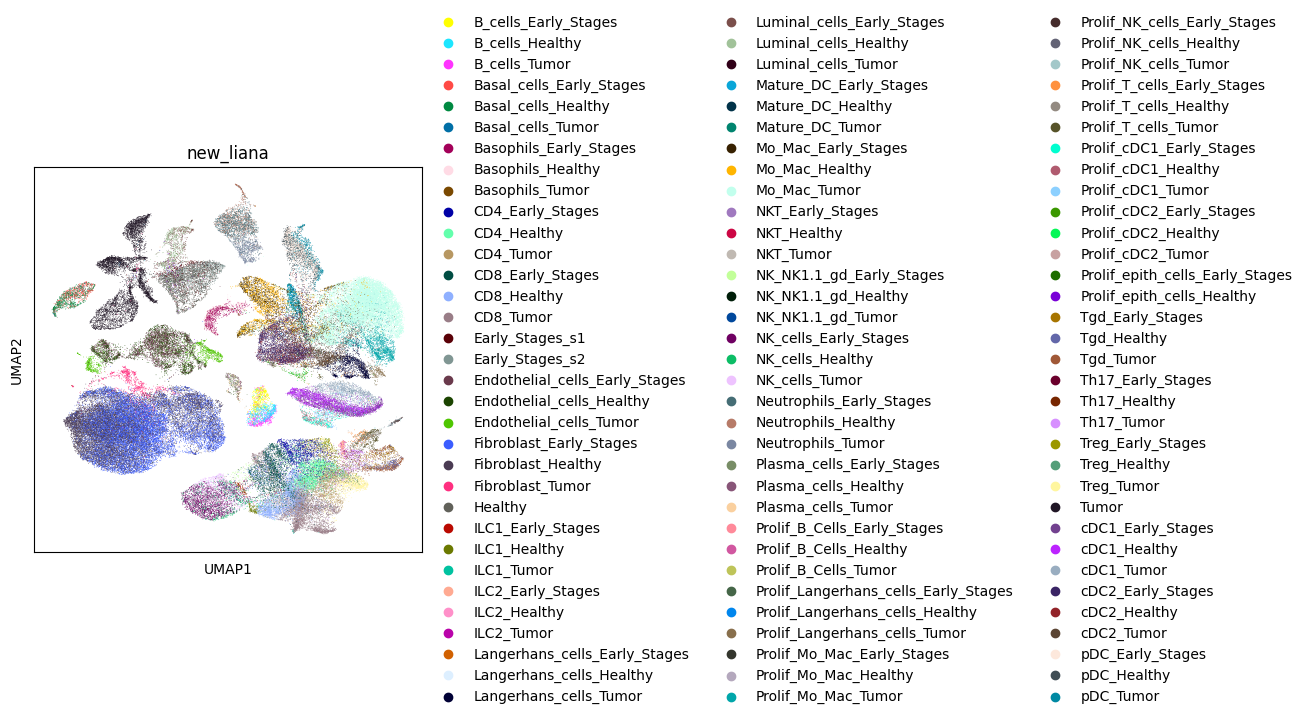

In [18]:
sc.pl.umap(adata, color = "new_liana")

In [26]:
from itertools import product


Stage = ["Healthy", "Early_Stages", "Tumor"]
source = ["B_cells", "CD4", "CD8"]
target = ["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"]

source = [f"{i[1]}_{i[0]}" for i in list(product(Stage, source))]


df_epi_target = pd.DataFrame(list(product(source, target)), columns=['source', 'target'])


df_epi_source = pd.DataFrame(list(product(target, source)), columns=['source', 'target'])

[('Healthy', 'B_cells'), ('Healthy', 'CD4'), ('Healthy', 'CD8'), ('Early_Stages', 'B_cells'), ('Early_Stages', 'CD4'), ('Early_Stages', 'CD8'), ('Tumor', 'B_cells'), ('Tumor', 'CD4'), ('Tumor', 'CD8')]


In [28]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='new_liana', expr_prop=0.1, 
            resource_name='mouseconsensus', verbose=True, 
            key_added='liana_res', groupby_pairs=df_epi_target)

Using `.raw`!
46 features of mat are empty, they will be removed.
Using resource `mouseconsensus`.
0.05 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 25790 samples and 25526 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 29.94it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|███████████████████████████████████████| 1000/1000 [10:35<00:00,  1.57it/s]


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


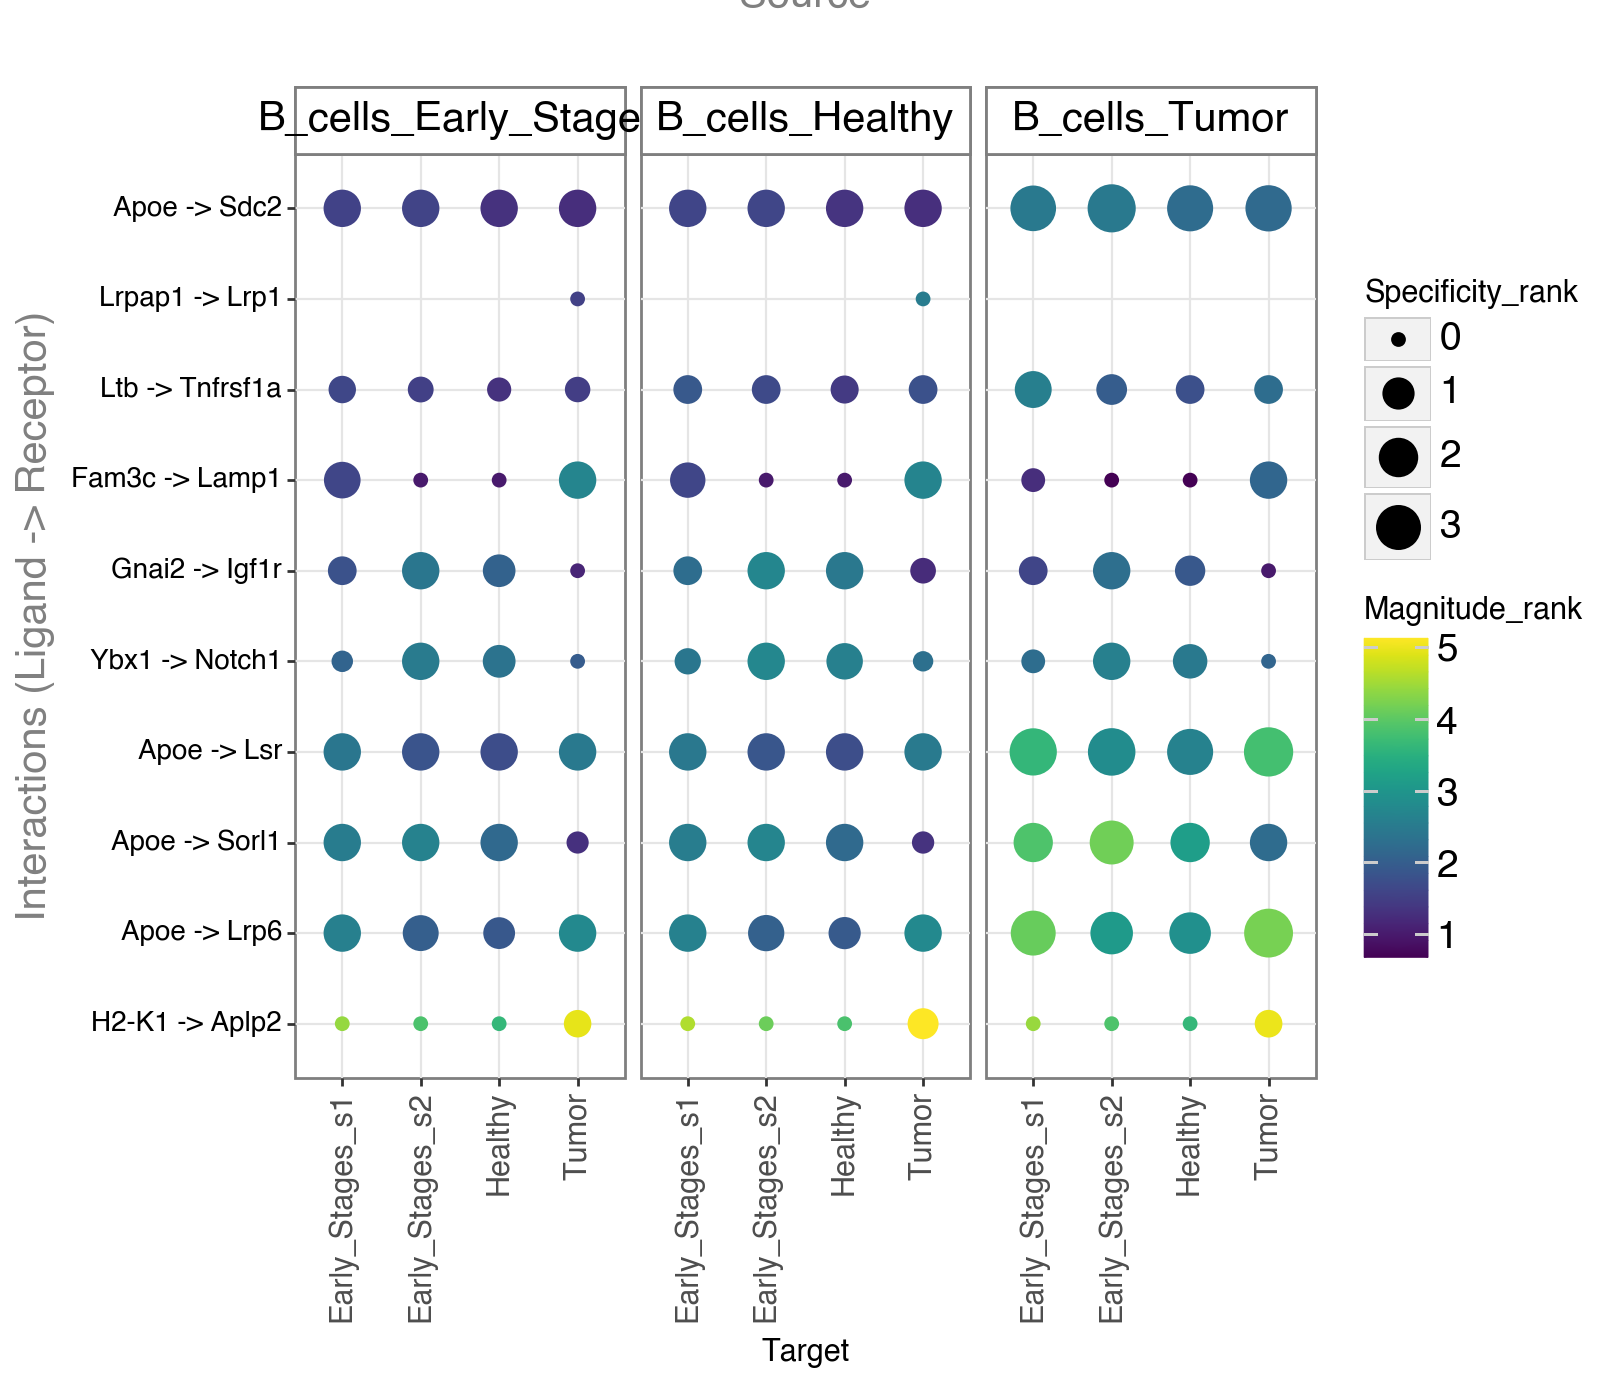

<Figure Size: (800 x 700)>

In [31]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=["B_cells_Early_Stages", "B_cells_Tumor", "B_cells_Healthy"],
              target_labels=["Healthy", "Early_Stages_s1", "Early_Stages_s2", "Tumor"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7),
              uns_key = "liana_res"
             )

<module 'scanpy' from '/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/__init__.py'>